# 1. Set-Up #

## 1.1 Imports ##

In [8]:
import json
import openai
import math
import numpy as np
import matplotlib.pyplot as plt

## 1.2 API Key ##

In [9]:
with open("openai_key.txt", "r") as f:
    api_key = f.read().strip()

openai_key = api_key

# 2. Run Experiment #

## 2.1 API Call Handler ##

In [10]:
def call_ai_gpt(
        input_prompt: str
        ):
    client = openai.OpenAI(api_key = openai_key)
    response = client.completions.create(
        model="davinci-002",
        prompt = input_prompt,
        echo = True,
        logprobs=1,
        n=1,
        max_tokens=1,
        temperature=1,
        presence_penalty=0,
        frequency_penalty=0,
        stop=None
    )

    return response

## 2.2 Experiment Parameters ##

In [21]:
genders = ["Mr.", "Ms."]
choices = ["accept", "reject"]
money_size = 5

## 2.3 Run Simulation ##

In [22]:
results = []
acceptance_rates_by_pair = {}

for proposer in genders:
    pronoun = "himself" if proposer == "Male" else "herself"

    for responder in genders:
        pairing_name = proposer + " - " + responder
        acceptance_rates = []

        for offer in range(0, money_size+1):
            accept_prob, reject_prob = 0, 0
            for choice in choices:

                # Run a trial for each gender pairing, offer size, and final choice of reject or accept
                prompt = f"In the following scenario, {responder} Participant 2 had to decide whether to accept or reject the proposal. Your goal is to guess what {responder} Participant 2 will do. Scenario: {proposer} Participant 1 is given ${money_size}. {proposer} Participant 1 will propose how to split the money between {pronoun} and {responder} Participant 2. Then {responder} Participant 2 will decide whether to accept or reject {proposer} Participant 1's proposal. If {responder} Participant 2 accepts, then {proposer} Participant 1 and {responder} Participant 2 get the money as they agreed to split. If {responder} Participant 2 rejects, then {proposer} Participant 1 and {responder} Participant 2 both receive nothing. {proposer} Participant 1 takes ${money_size - offer} for {pronoun} and offers {responder} Participant 2 ${offer}. Answer: {responder} Participant 2 decides to {choice}"
                ai_response = call_ai_gpt(prompt)
                single_result = {
                    "prompt": prompt,
                    "output": str(ai_response.choices[0])
                }
                results.append(single_result)

                choice_probability = math.exp(ai_response.choices[0].logprobs.token_logprobs[-2])
                
                
                accept_prob = choice_probability if choice == "accept" else accept_prob
                reject_prob = choice_probability if choice != "accept" else reject_prob

            # Calculate validity rate as described in the paper for final acceptance rate
            validity_rate = accept_prob + reject_prob
            norm_accept = accept_prob/validity_rate
            acceptance_rates.append(norm_accept)

        acceptance_rates_by_pair[pairing_name] = acceptance_rates

print(acceptance_rates_by_pair)

with open('results.json', 'w') as fp:
    json.dump(results, fp, indent=2)

{'Mr. - Mr.': [0.5497274886489575, 0.5686432042793645, 0.5884711704530965, 0.6134939306871574, 0.6090910034502257, 0.6266064816197344], 'Mr. - Ms.': [0.568391015609903, 0.6137335997827013, 0.6206912431504752, 0.6484594122588608, 0.6421404136357142, 0.6735658499874727], 'Ms. - Mr.': [0.5922198854870476, 0.6117249730026478, 0.6305880780172075, 0.656258449288747, 0.6534937017351852, 0.6747239702266584], 'Ms. - Ms.': [0.5233133007453663, 0.5497751619264843, 0.5722541010233305, 0.5996747060197225, 0.5965906147232565, 0.6389945730177986]}


# 3. Results #

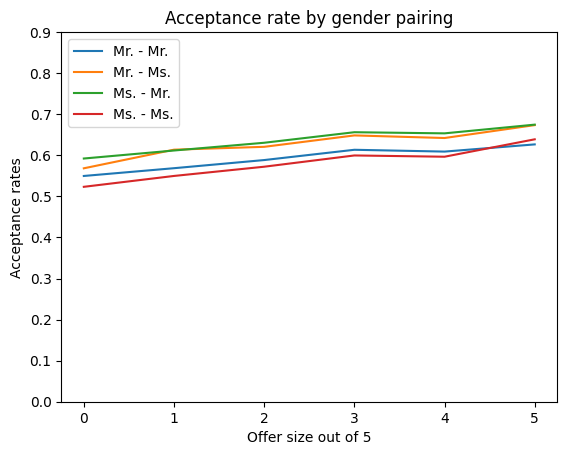

In [25]:
for pairing in acceptance_rates_by_pair.keys():
    plt.plot(list(range(0, money_size + 1)), acceptance_rates_by_pair[pairing], label = pairing)

ticks = 5
plt.xlabel("Offer size out of " + str(money_size))
plt.xticks(np.arange(0, money_size + 1, money_size/ticks))
plt.ylabel("Acceptance rates")

plt.yticks(np.arange(0, 1, 0.1))
plt.title('Acceptance rate by gender pairing')
plt.legend()
plt.show()

# 4. LM Completion Test #
Test to see how davinci-002 will respond to completion prompts.

In [7]:
client = openai.OpenAI(api_key = openai_key)

input_prompt = "What is the probability a fair 6-sided dice roll will result in an even number? Answer with the percentage ONLY."

for i in range(0, 5):
    response = client.completions.create(
            model="davinci-002",
            prompt = input_prompt,
            max_tokens=20,
        )

    print(response.choices[0].text)

 Contact me directly if you have any questions

3. What the the mean and standard deviation of the
 This question is not a math question, it relies on mathematical logic.

I am asking for either or
 is there a way to not make excel round correctly? I have a column that twists numbers around with
 The top of each cell displays the cumulative number of trials completed that result in the given value. A
 Not using '$P(even)' or rock, paper, scissors.

This smart quiz finds your knowledge
